In [1]:
%pylab inline
import uuid
import base64
import cPickle as pickle
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')
import os

Populating the interactive namespace from numpy and matplotlib


In [101]:

benchmark_data = pickle.load(open("flops_benchmark.pickle", 'r'))

callset_id = benchmark_data['callset_id']

In [102]:

invoke_df = pd.DataFrame(benchmark_data['results'])
results_df = pd.DataFrame(benchmark_data['run_statuses'])


In [103]:
results_df = pd.concat([results_df, invoke_df], axis=1)

In [104]:
results_df['runtime_cached'].value_counts()

False    448
True     352
Name: runtime_cached, dtype: int64

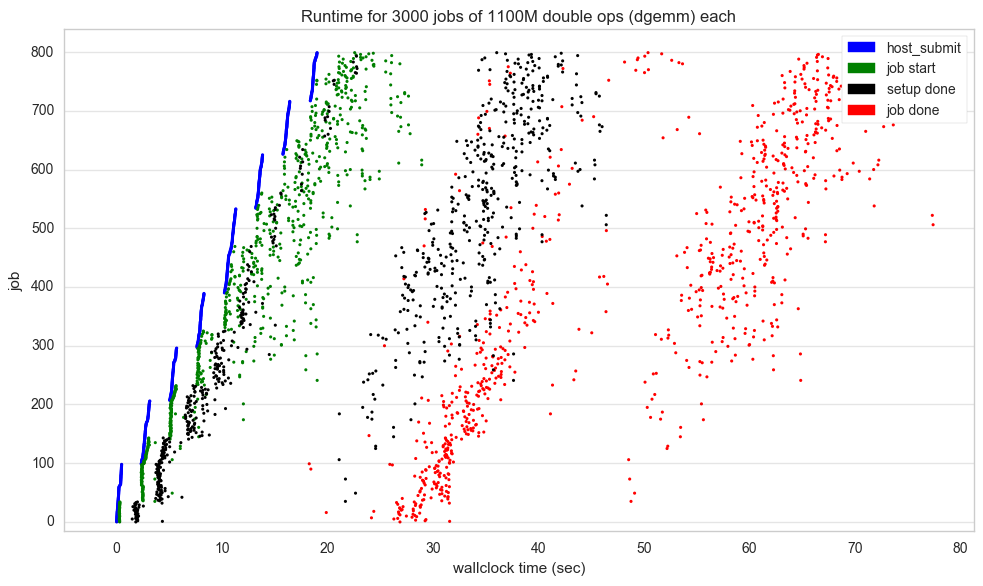

In [105]:

time_offset = np.min(results_df.host_submit_time)
fig = pylab.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
total_jobs = len(results_df)

y = np.arange(total_jobs)
point_size = 5
ax.scatter(results_df.host_submit_time - time_offset, y, c='b', edgecolor='none', s=point_size)
ax.scatter(results_df.start_time - time_offset, y, c='g', edgecolor='none', s=point_size)
ax.scatter(results_df.end_time - time_offset, y, c='r', edgecolor='none', s=point_size)
ax.scatter(results_df.start_time + results_df.setup_time - time_offset,
y, c='k', edgecolor='none', s=point_size)
ax.set_xlabel('wallclock time (sec)')
ax.set_ylabel('job')
#pylab.ylim(0, 10)

import matplotlib.patches as mpatches

host_submit_patch = mpatches.Patch(color='b', label='host_submit')
job_start_patch = mpatches.Patch(color='g', label='job start')
setup_done_patch = mpatches.Patch(color='k', label='setup done')

job_done_patch = mpatches.Patch(color='red', label='job done')

legend = pylab.legend(handles=[host_submit_patch, job_start_patch, setup_done_patch, job_done_patch, ],
                      loc='upper right', frameon=True)
pylab.title("Runtime for 3000 jobs of 1100M double ops (dgemm) each")
legend.get_frame().set_facecolor('#FFFFFF')



plot_step = 100  #int(np.min([128, total_jobs/32]))
y_ticks = np.arange(total_jobs//plot_step + 2) * plot_step
ax.set_yticks(y_ticks)
ax.set_ylim(-0.02*total_jobs, total_jobs*1.05)

ax.set_xlim(-5, np.max(results_df.end_time - time_offset)*1.05)
for y in y_ticks:
    ax.axhline(y, c='k', alpha=0.1, linewidth=1)
 
ax.grid(False)
fig.tight_layout()
#fig.savefig("flops_benchmark.timeline.png")

In [106]:
test_index = np.arange(len(results_df.end_time))
t = np.sort(results_df.end_time) - time_offset
JOB_GFLOPS = 2 * 4096**3  *6 /1e9

In [107]:
# now compute peak 
runtime_bins = np.linspace(0, 220, 220)
runtime_flops_hist = np.zeros((len(results_df), len(runtime_bins)))
for i in range(len(results_df)):
    row = results_df.iloc[i]
    s = (row.start_time + row.setup_time) - time_offset
    e = row.end_time - time_offset
    a, b = np.searchsorted(runtime_bins, [s, e])
    if b-a > 0:
        runtime_flops_hist[i, a:b] = JOB_GFLOPS / float(b-a)


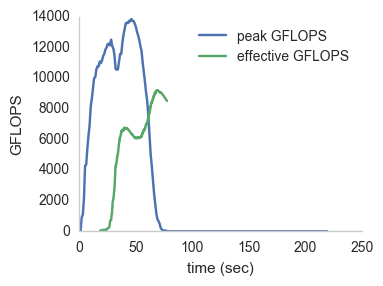

In [108]:
fig = pylab.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(runtime_flops_hist.sum(axis=0), label='peak GFLOPS')
ax.plot(t, test_index* JOB_GFLOPS/t, label='effective GFLOPS')
ax.set_xlabel('time (sec)')
ax.set_ylabel("GFLOPS")
pylab.legend()
ax.grid(False)
sns.despine()
fig.tight_layout()
fig.savefig("flops_benchmark.gflops.png")

In [109]:
# examine runtime caching
# how many jobs on how many nodes
results_df.hw_addr.value_counts()

EE:58:18:FF:10:5A    2
46:A8:63:4D:52:C8    1
8E:C2:A1:BB:97:33    1
AE:AF:9C:08:4F:3A    1
CE:3D:B9:50:5C:9F    1
C6:26:5A:10:5B:D0    1
3E:4F:F6:15:EE:2E    1
E6:5A:D7:79:9A:6D    1
8E:7B:73:C0:11:5D    1
42:D8:AA:A7:32:26    1
06:35:C9:C6:90:F8    1
6E:FB:C3:53:0E:50    1
DA:6D:A4:3D:EA:9D    1
3E:61:70:1A:52:7D    1
BA:ED:44:C9:D6:FD    1
12:91:86:BD:22:C1    1
A2:E8:FE:95:7F:7E    1
F2:C6:72:BF:38:23    1
6E:07:CB:2C:47:FD    1
EA:C8:B3:5D:E1:BA    1
B2:67:F4:D1:2A:F5    1
82:57:3C:AD:FD:A3    1
8A:C0:89:0A:0E:F8    1
A2:C1:8A:51:56:33    1
9E:22:56:20:97:7F    1
4E:77:6B:FE:CD:46    1
7E:02:48:3A:F8:3C    1
7A:48:B8:43:12:4D    1
36:B8:38:DF:4F:E1    1
12:F7:71:76:EE:A0    1
                    ..
02:EA:FB:E5:12:0B    1
BA:BB:7A:5F:0A:A4    1
E2:00:EB:D0:68:61    1
E6:28:7C:46:99:57    1
02:9C:21:70:AE:73    1
36:EF:48:60:89:F9    1
22:9F:43:8D:23:58    1
6E:58:99:E2:33:B8    1
12:6A:0F:C6:D9:E8    1
A2:AF:57:29:E7:5D    1
4E:8C:83:6E:69:D1    1
86:D0:CF:57:B5:80    1
FA:99:DA:0F

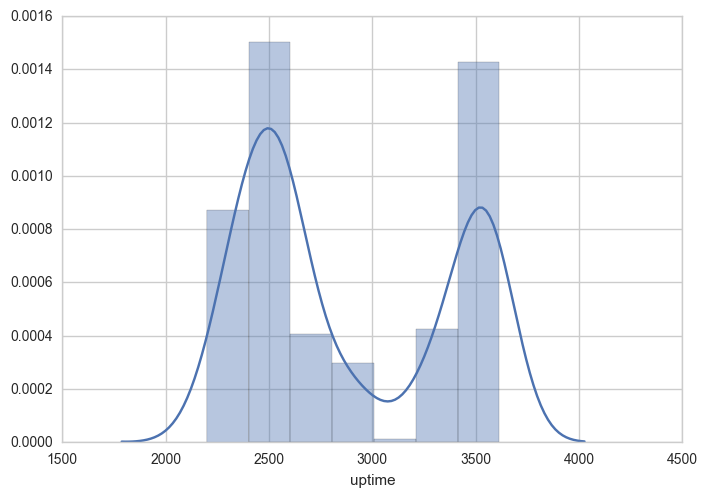

In [110]:
sns.distplot(results_df.uptime)

In [10]:
log_group_name = results[0]['log_group_name']
log_stream_name = results[0]['log_stream_name']
aws_request_id = results[0]['aws_request_id']
events = logsclient.get_log_events(logGroupName=log_group_name, 
                              logStreamName=log_stream_name)

In [11]:
for e in events['events']:
    if 'REPORT' in e['message'] :
        print e['message']

REPORT RequestId: da314b94-a39f-11e6-8b46-352e391c8a84	Duration: 69034.44 ms	Billed Duration: 69100 ms 	Memory Size: 1536 MB	Max Memory Used: 899 MB	

REPORT RequestId: 56f943f7-a3a0-11e6-aec0-a1f502948a4e	Duration: 54249.77 ms	Billed Duration: 54300 ms 	Memory Size: 1536 MB	Max Memory Used: 900 MB	



In [12]:
results[0]['end_time'] - results[0]['start_time']

53.95095109939575

In [13]:
all_times = end_times-start_times
price_per_100ms = 0.000002501
costs = all_times * 10.0 * price_per_100ms
print np.sum(costs)

0.159545367046


In [14]:
np.sum(all_times) / 60/ 60.0

1.7720174935128954

In [15]:
# parse the logs
loglines = open("/data/jonas/pywren/examples/benchmark.log", 'r').readlines()


In [16]:
[l for l in loglines if "b5498f4e-6087-49c5-ad9d-7421c84a778d 00084" in l]



[]